In [15]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, confusion_matrix, accuracy_score, recall_score
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, OrdinalEncoder
import datetime
import os
import csv
import math
import itertools
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [16]:
# Parámetros
inputFolder = "1-input"
processFolder = "2-process"
outputFolder = "3-output"
logsFolder = "4-logs"

outputAllFolder = outputFolder + r"\all"
outputSummaryFolder = outputFolder + r"\summary"

otherOutputFolder = "../5-evaluation/1-input/algorithms/"

resultsFolder = "../results/1-input/1-pretest/"

dataVisualizationTopLimit = 20

testSize = 0.25
genericRandomState = 0
splitRandomState = 0
samplingStrategy = 0.25
percentileNumberStd = 90
percentileNumberCorrelation = 90

iterationsNumber = 8

In [17]:
classifiers = {
  "K vecinos más cercanos": { "name": "K vecinos más cercanos", "acronym": "KNN", "classifier": KNeighborsClassifier(weights="uniform", algorithm="ball_tree", p=1) }, 
  "Máquina de vectores de soporte": { "name": "Máquina de vectores de soporte", "acronym": "SVM", "classifier": SVC(random_state=genericRandomState) }, 
  "Regresión logística": { "name": "Regresión logística", "acronym": "LR", "classifier": LogisticRegression(random_state=genericRandomState, max_iter=200, solver="saga") }, 
  "Árbol de decisión": { "name": "Árbol de decisión", "acronym": "DT", "classifier": DecisionTreeClassifier(random_state=genericRandomState, criterion="gini", splitter="best", max_depth=200 ) }, 
  "Bosque aleatorio": { "name": "Bosque aleatorio", "acronym": "RF", "classifier": RandomForestClassifier(random_state=genericRandomState) }, 
  "Aumento de gradiente": { "name": "Aumento de gradiente", "acronym": "GBM", "classifier": GradientBoostingClassifier(random_state=genericRandomState, n_estimators=200) }, 
}

In [18]:
# Funciones utilitarias de archivos
def readCsvAsDict(filePath, delimiter=",", encoding="utf-8", header=0, dtype={}):
  df = pd.read_csv(filePath, delimiter=delimiter,encoding=encoding, header=header, dtype=dtype)
  df = df.replace(np.nan, '', regex=True)
  data = df.to_dict('records')
  return data

def readCsvAsDf(filePath, delimiter=",", encoding="utf-8", header=0, dtype={}):
  df = pd.read_csv(filePath, delimiter=delimiter,encoding=encoding, header=header, dtype=dtype)
  df = df.replace(np.nan, '', regex=True)
  return df

def writeDictToCsv(data, pathCsv, encoding='utf-8'):
  with open(pathCsv, 'w', newline='', encoding=encoding) as f:
    if data:
      writer = csv.DictWriter(f, fieldnames=data[0].keys(), lineterminator='\n')
      writer.writeheader()
      writer.writerows(data)
    else:
      f.write("")

def writeDfToCsv(data, pathCsv, encoding='utf-8', header=True):
  data.to_csv(path_or_buf = pathCsv, encoding = encoding, header=header, index=False)

def parseTranspose(df):
  transposedDf = df.transpose()
  transposedDf = transposedDf.reset_index()
  transposedDf.columns = transposedDf.iloc[0]
  transposedDf = transposedDf[1:]

  return transposedDf

In [19]:
def showOversampling(df):
  colors = ["tab:blue", "tab:green"]
  topDf = df["contratado"].astype(str).value_counts().head(dataVisualizationTopLimit)
  print(topDf)
  classes = list(topDf.index)
  values = list(topDf.values)
  graph = plt.bar(classes, values, color=colors)

  percentage = []
  for value in values:
    pct = (value / sum(values)) * 100
    percentage.append(round(pct,2))

  for index, p in enumerate(graph):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x+width/2, y+height+50, str(percentage[index])+'%', ha='center', weight='bold')

  plt.xlabel("Contratado")
  plt.ylabel("Número de postulantes")
  plt.title("Número de postulantes contratados y no contratados")
  plt.show()

def showDifferentValues(df):
  categoricalColumns = [columnName for columnName, columnType in df.dtypes.to_dict().items() if columnName not in [ "contratado" ] and columnType == "object" ]
  categoricalCardinalColumns = [columnName for columnName in categoricalColumns if columnName not in [ "estadoUltimoEstudio", "gradoUltimoEstudio" ]]

  seriesDf = df.nunique().filter(items=categoricalCardinalColumns)
  resultDf = pd.DataFrame({'column': seriesDf.index, 'differentValuesNumber': seriesDf.values})
  resultDf.index = range(1,len(resultDf)+1)
  
  display(resultDf)

def showMaxMinNumerical(df):
  numericalColumns = [columnName for columnName, columnType in df.dtypes.to_dict().items() if columnName not in [ "contratado" ] and columnType == "float64" ]

  minSeriesDf = df.min().filter(items=numericalColumns)
  maxSeriesDf = df.max().filter(items=numericalColumns)
  resultDf = pd.DataFrame({'column': numericalColumns, 'minValue': minSeriesDf.values, 'maxValue': maxSeriesDf.values})
  resultDf.index = range(1,len(resultDf)+1)

  display(resultDf)

In [20]:
def showMetricsCharts(metricsList, context, unit):
  metrics = [
    {"exactitud": "Exactitud"},
    {"precision": "Precisión"},
    {"sensibilidad": "Sensibilidad"},
    {"robustez": "Robustez"},
    {"tiempo": "Tiempo"},
    {"promedioMetricas": "Promedio de métricas"},
  ]

  for metric in metrics:
    key = list(metric.keys())[0]
    value = metric[key]

    if key != "tiempo":
      data = {}
      for elem in metricsList:
        data["\n".join(elem[context].split(" "))] = float(elem[key])
      
      keys = list(data.keys())
      values = list(data.values())
        
      fig = plt.figure(figsize = (10, 5))
      
      sortedValues = sorted(values)
      maxValue = sortedValues[len(sortedValues)-1]
      colors = ['tab:red' if (elem == maxValue) else 'tab:blue' for elem in values]
      plt.bar(keys, values, width = 0.4, color=colors)
      
      plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
      plt.ylabel("Porcentaje")
      plt.title("{} por {}".format(value, unit))
      plt.show()
    else:
      data = {}
      for elem in metricsList:
        data["\n".join(elem[context].split(" "))] = float(elem[key])
      
      keys = list(data.keys())
      values = list(data.values())
        
      fig = plt.figure(figsize = (10, 5))
          
      sortedValues = sorted(values, reverse=True)
      maxValue = sortedValues[len(sortedValues)-1]
      colors = ['tab:red' if (elem == maxValue) else 'tab:blue' for elem in values]
      plt.bar(keys, values, width = 0.4, color=colors)
      
      plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, y: "{:.0f}".format(x) + "s"))
      plt.ylabel("Segundos")
      plt.title("{} por {}".format(value, unit))
      plt.show()

In [21]:
def preprocessingData(inputPath):
  # Leyendo datos
  df = readCsvAsDf(inputPath)

  showOversampling(df)

  # Balanceo de datos: Sobremuestreo aleatorio (oversampling) (1 de cada 5)
  objectiveColumn = "contratado"
  dictResults = dict(df[objectiveColumn].value_counts().sort_index())

  maxKey = max(dictResults, key=dictResults.get)
  maxValue = max(dictResults.values())

  dfClassMaxKey = df[df[objectiveColumn] == maxKey]

  for key in dictResults.keys():
    if key != maxKey:
      dfClass = df[df[objectiveColumn] == key]
      dfClassSampled = dfClass.sample(int(maxValue * samplingStrategy), random_state=genericRandomState, replace=True)
      dfClassMaxKey = pd.concat([dfClassMaxKey, dfClassSampled],axis=0)

  df = dfClassMaxKey

  showOversampling(df)

  # Aleatorizacion del orden de los registros para evitar sesgos(filas)
  df = df.sample(frac = 1, random_state=genericRandomState).reset_index(drop=True)

  # Aplicando OrdinalEncoding a las variables categóricas ordinales()
  encoder = OrdinalEncoder(categories=[[ "Abandonado", "En Curso", "Graduado" ]])
  encoder.fit(df[["estadoUltimoEstudio"]])
  df["estadoUltimoEstudio"] = encoder.transform(df[["estadoUltimoEstudio"]])
  encoder = OrdinalEncoder(categories=[[ "Otro", "Secundario", "Terciario/Tecnico", "Universitario", "Posgrado", "Master", "Doctorado" ]])
  encoder.fit(df[["gradoUltimoEstudio"]])
  df["gradoUltimoEstudio"] = encoder.transform(df[["gradoUltimoEstudio"]])

  showDifferentValues(df)
  
  # Aplicando OneHotEncoding a las variables categóricas cardinales (transformación a numéricas mediante columnas)
  categoricalColumns = [columnName for columnName, columnType in df.dtypes.to_dict().items() if columnName not in [ "contratado" ] and columnType == "object" ]
  categoricalCardinalColumns = [columnName for columnName in categoricalColumns if columnName not in [ "estadoUltimoEstudio", "gradoUltimoEstudio" ]]

  for column in categoricalCardinalColumns:
    dummies = pd.get_dummies(df[[column]], prefix=column) # El dummy_na te genera una columna, asi tenga na's o no
    df = pd.concat([df, dummies], axis = 1)
    df = df.drop(columns=[column])

  showMaxMinNumerical(df)

  # Aplicando MinMaxScaler a las variables numéricas (normalización) (esto tambien incluye a lastEducationStatus y lastEducationDegree, ya numéricas)
  # Algunas quedaran en 0.9999, esto porque no todas manejan la misma escala (sin decimales, o solo un decimal)
  numericalColumns = [columnName for columnName, columnType in df.dtypes.to_dict().items() if columnName not in [ "contratado" ] and columnType == "float64" ]

  for column in numericalColumns:
    df[column] = df[column].fillna(0.0)
  mms = MinMaxScaler()
  df[numericalColumns] = mms.fit_transform(df[numericalColumns])

  print(len(df.columns))

  # Eliminando columnas con varianza cercana a cero, dejando el 10% de columnas con mayor varianza (variables no afectan en el resultado del modelo)
  df.loc['std'] = df.std()
  stdArray = df.iloc[len(df)-1]
  nthPercentileStd = np.percentile(stdArray, percentileNumberStd)
  print(nthPercentileStd)
  df = df.transpose()
  df = df[df["std"]>nthPercentileStd]
  df = df.transpose()
  df = df.drop(['std'], axis=0)

  print(len(df.columns))

  # Eliminando columnas con correlación cercana a uno, dejando el 90% de columnas con menor correlación
  correlationMatrix = df.corr().abs()
  correlationMatrix[correlationMatrix == 1.0] = 0.0
  maxCorrelationValues = [max(correlationMatrix[column]) for column in correlationMatrix.columns]
  nthPercentileCorrelation = np.percentile(maxCorrelationValues, percentileNumberCorrelation)
  print(nthPercentileCorrelation)
  highCorrelationColumns = [column for column in correlationMatrix.columns if max(correlationMatrix[column]) > nthPercentileCorrelation]
  df = df.drop(highCorrelationColumns, axis=1)

  print(len(df.columns))

  writeDfToCsv(df, os.path.join(processFolder, 'result.csv'))

  return df

In [22]:
def splitData(X, y, iteration):
  # Dividiendo los dataframes de entrenamiento y prueba
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = testSize, random_state=iteration)

  return X_train, X_test, y_train, y_test

In [23]:
def trainModel(X_train, X_test, y_train, y_test, algorithm):
  # Creación del clasificador
  clf = classifiers[algorithm]["classifier"]

  # Entrenamiento del clasificador
  clf.fit(X_train, y_train)

  # Calculando la predicción del modelo con la data de prueba
  y_pred = clf.predict(X_test)

  return y_test, y_pred

In [24]:
def getMetrics(y_train, y_test, y_pred, startDate, endDate, algorithm, iterationNumber = None, technique = None, partitionNumber = None):
  trainRows = len(y_train)
  testRows = len(y_test)

  # Calculando la exactitud del modelo
  accuracy = accuracy_score(y_test, y_pred)

  # Calculando la precisión del modelo
  precision = precision_score(y_test, y_pred)

  # Calculando la sensibilidad del modelo
  recall = recall_score(y_test, y_pred)

  # Calculando el valor F del modelo (robustez)
  f1Score = f1_score(y_test, y_pred)

  # Calculando el promedio de métricas
  metricsList = [accuracy, precision, recall, f1Score]
  metricsMean = sum(metricsList) / len(metricsList)

  # Calculando el tiempo de ejecución del modelo
  executionTime = (endDate - startDate).total_seconds()

  # Obteniendo la matriz de confusión
  confussionMatrix = str(confusion_matrix(y_test, y_pred).tolist())
  
  return {
    "sigla": classifiers[algorithm]["acronym"],
    "algoritmo": algorithm,
    "tecnica": technique if technique is not None else "Ninguna",
    "iteracion": "Iteración {}".format(iterationNumber) if iterationNumber is not None else "Total de datos",
    "particion": "Partición {}".format(partitionNumber) if partitionNumber is not None else "Total de datos",
    "registrosEntrenamiento": trainRows,
    "registrosPrueba": testRows,
    "proporcionSobremuestreo": samplingStrategy,
    "matrizConfusion": confussionMatrix,
    "exactitud": "{:.4f}".format(accuracy),
    "precision": "{:.4f}".format(precision),
    "sensibilidad": "{:.4f}".format(recall),
    "robustez": "{:.4f}".format(f1Score),
    "tiempo": "{:.4f}".format(executionTime),
    "promedioMetricas": "{:.4f}".format(metricsMean),
  }

In [25]:
def modelling(df):
  # Lectura de las variables de características y objetivo
  objectiveColumn = "contratado"
  X = df.drop([objectiveColumn], axis=1)
  y = df[objectiveColumn]

  # Creando el arreglo de metricas de cada algoritmo
  algorithmsMetricsList = []

  # Definiendo los algoritmos a usar
  algorithms = classifiers.keys()

  # Iterando por cada algoritmo
  for algorithm in algorithms:
    
    # Iterando por cada iteración
    for iterationNumber in range(0, iterationsNumber):

      # Mostrando que algoritmo se usa
      print("Ejecutando para: Algoritmo {} - Iteración {}".format(algorithm, iterationNumber+1))

      # Inicio de ejecución
      startDate = datetime.datetime.now()

      # Separando data para el entrenamiento y testeo
      X_train, X_test, y_train, y_test = splitData(X, y, iterationNumber)

      # Realizar entrenamiento del modelo
      y_test, y_pred = trainModel(X_train, X_test, y_train, y_test, algorithm)

      # Fin de ejecución del modelo
      endDate = datetime.datetime.now()

      # Obteniendo las métricas de la partición del modelo
      algorithmMetrics = getMetrics(y_train, y_test, y_pred, startDate, endDate, algorithm, iterationNumber=iterationNumber+1)

      # Añadiendo la métrica de la partición a la lista de métricas
      algorithmsMetricsList.append(algorithmMetrics)
  
  # Pasandolo a df
  algorithmsMetricsListDf = pd.DataFrame(algorithmsMetricsList)
  algorithmsMetricsListTransposedDf = parseTranspose(algorithmsMetricsListDf)
  
  writeDfToCsv(algorithmsMetricsListDf, os.path.join(outputAllFolder, 'result.csv'))
  writeDfToCsv(algorithmsMetricsListTransposedDf, os.path.join(outputAllFolder, 'result_transposed.csv'))

  writeDfToCsv(algorithmsMetricsListDf, os.path.join(resultsFolder, 'result.csv'))
  writeDfToCsv(algorithmsMetricsListTransposedDf, os.path.join(resultsFolder, 'result_transposed.csv'))

  return algorithmsMetricsList

In [26]:
def getSummary(metricsList, context):
  summary = []
  metricsList = sorted(metricsList, key=lambda x: list(classifiers.keys()).index(x[context]))
  for key, value in itertools.groupby(metricsList, key=lambda x:x[context]):
    copyValue = list(value).copy()
    summary.append({
      "sigla": classifiers[key]["acronym"],
      "algoritmo": key,
      "exactitud": "{:.4f}".format(sum(float(elem["exactitud"]) for elem in copyValue) / len(copyValue)),
      "precision": "{:.4f}".format(sum(float(elem["precision"]) for elem in copyValue) / len(copyValue)),
      "sensibilidad": "{:.4f}".format(sum(float(elem["sensibilidad"]) for elem in copyValue) / len(copyValue)),
      "robustez": "{:.4f}".format(sum(float(elem["robustez"]) for elem in copyValue) / len(copyValue)),
      "tiempo": "{:.4f}".format(sum(float(elem["tiempo"]) for elem in copyValue) / len(copyValue)),
      "promedioMetricas": "{:.4f}".format(sum(float(elem["promedioMetricas"]) for elem in copyValue) / len(copyValue)),
    })

  return summary

In [27]:
def main():
  # Definiendo el inicio del proceso
  startTime = datetime.datetime.now()
  print("Inicio: " + str(startTime))
  print()

  isPreprocessed = True
  isModelled = False

  # Preprocesando los datos
  print("Preprocesando datos")
  df = readCsvAsDf(os.path.join(processFolder, "result.csv")) if isPreprocessed else preprocessingData(os.path.join(inputFolder, "result.csv"))
  
  # Obteniendo la lista completa de métricas
  print("Entrenando el modelo")
  algorithmsMetricsList = readCsvAsDict(os.path.join(outputAllFolder, 'result.csv')) if isModelled else modelling(df)

  # Obteniendo el resumen por algoritmo
  algorithmsSummary = getSummary(algorithmsMetricsList, "algoritmo")

  # Escribiendo resumen
  summaryDf = pd.DataFrame(algorithmsSummary)
  summaryTransposedDf = parseTranspose(summaryDf)
  writeDfToCsv(summaryDf, os.path.join(outputSummaryFolder, 'result.csv'))
  writeDfToCsv(summaryTransposedDf, os.path.join(outputSummaryFolder, 'result_transposed.csv'))
  writeDfToCsv(summaryDf, os.path.join(otherOutputFolder, 'result.csv'))
  writeDfToCsv(summaryTransposedDf, os.path.join(otherOutputFolder, 'result_transposed.csv'))
  
  # Mostrando gráficos
  showMetricsCharts(algorithmsSummary, "algoritmo", "modelo")

  # Elegir el algoritmo con mayor promedio de métricas
  maxAverageAlgorithm = max(algorithmsSummary, key=lambda x:x["promedioMetricas"])

  print("Algoritmo con mayor promedio de métricas: {}".format(maxAverageAlgorithm["algoritmo"]))
  print("Exactitud: {:.2%}".format(float(maxAverageAlgorithm["exactitud"])))
  print("Precisión: {:.2%}".format(float(maxAverageAlgorithm["precision"])))
  print("Sensibilidad: {:.2%}".format(float(maxAverageAlgorithm["sensibilidad"])))
  print("Robustez: {:.2%}".format(float(maxAverageAlgorithm["robustez"])))
  print("Tiempo: {:.2f}s".format(float(maxAverageAlgorithm["tiempo"])))
  print("Promedio de métricas: {:.2%}".format(float(maxAverageAlgorithm["promedioMetricas"])))
  print()

  # Definiendo el fin del proceso
  endTime = datetime.datetime.now()
  print("Fin: " + str(endTime))
  print("Tiempo: " + str(endTime-startTime))

Inicio: 2023-07-06 10:29:17.742798

Preprocesando datos
Entrenando el modelo
Ejecutando para: Algoritmo K vecinos más cercanos - Iteración 1
Ejecutando para: Algoritmo K vecinos más cercanos - Iteración 2
Ejecutando para: Algoritmo K vecinos más cercanos - Iteración 3
Ejecutando para: Algoritmo K vecinos más cercanos - Iteración 4
Ejecutando para: Algoritmo K vecinos más cercanos - Iteración 5
Ejecutando para: Algoritmo K vecinos más cercanos - Iteración 6
Ejecutando para: Algoritmo K vecinos más cercanos - Iteración 7
Ejecutando para: Algoritmo K vecinos más cercanos - Iteración 8
Ejecutando para: Algoritmo Máquina de vectores de soporte - Iteración 1
Ejecutando para: Algoritmo Máquina de vectores de soporte - Iteración 2
Ejecutando para: Algoritmo Máquina de vectores de soporte - Iteración 3
Ejecutando para: Algoritmo Máquina de vectores de soporte - Iteración 4
Ejecutando para: Algoritmo Máquina de vectores de soporte - Iteración 5
Ejecutando para: Algoritmo Máquina de vectores de s

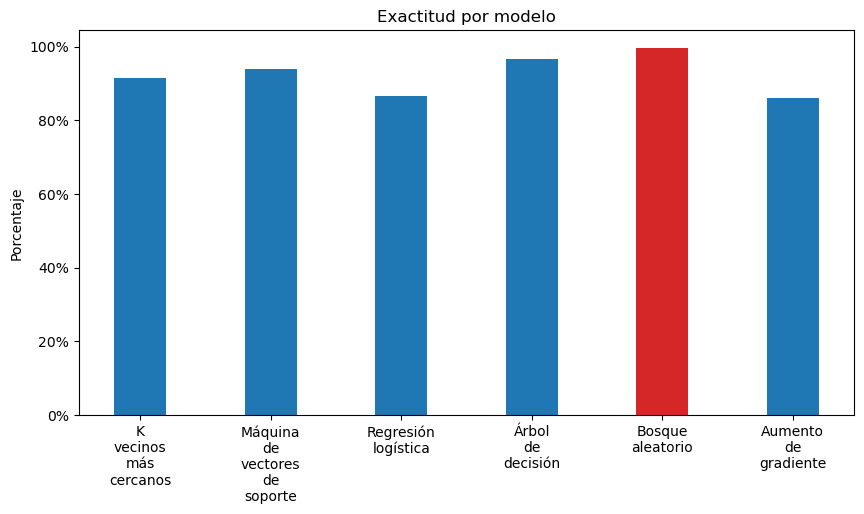

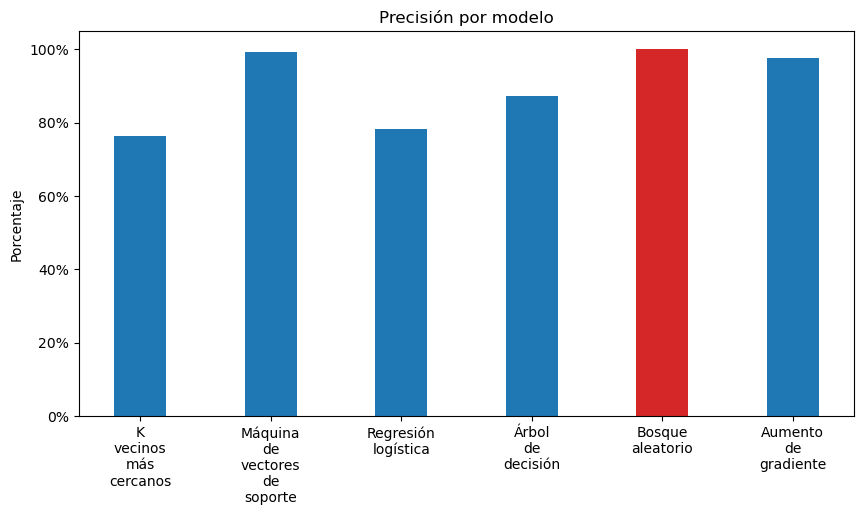

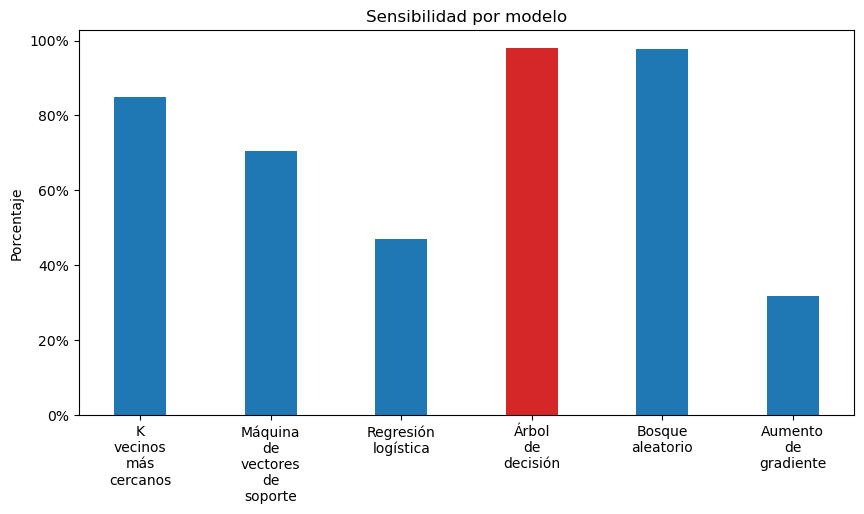

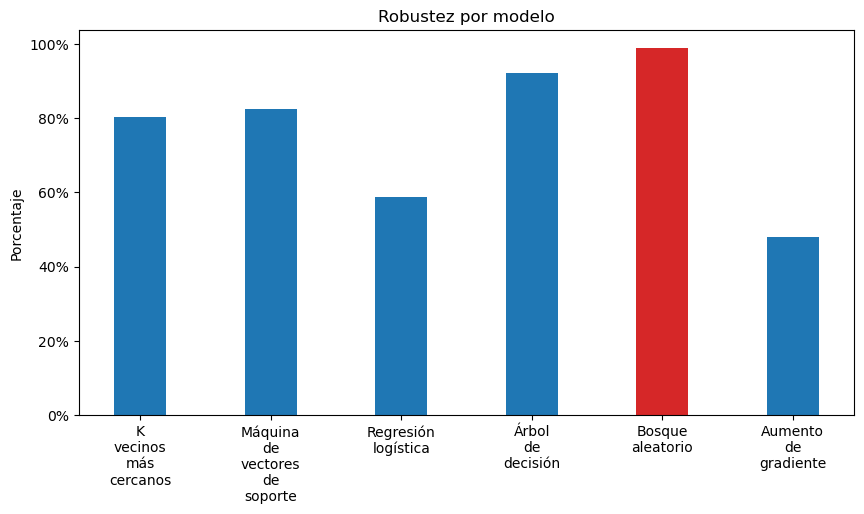

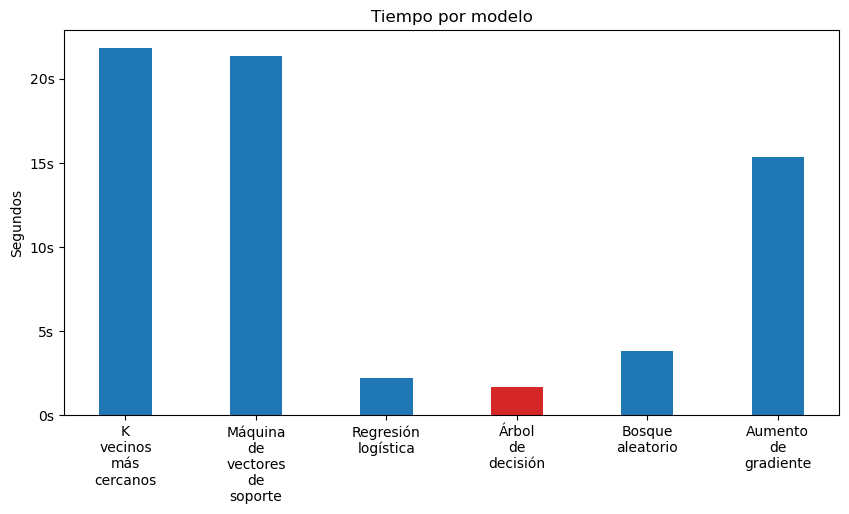

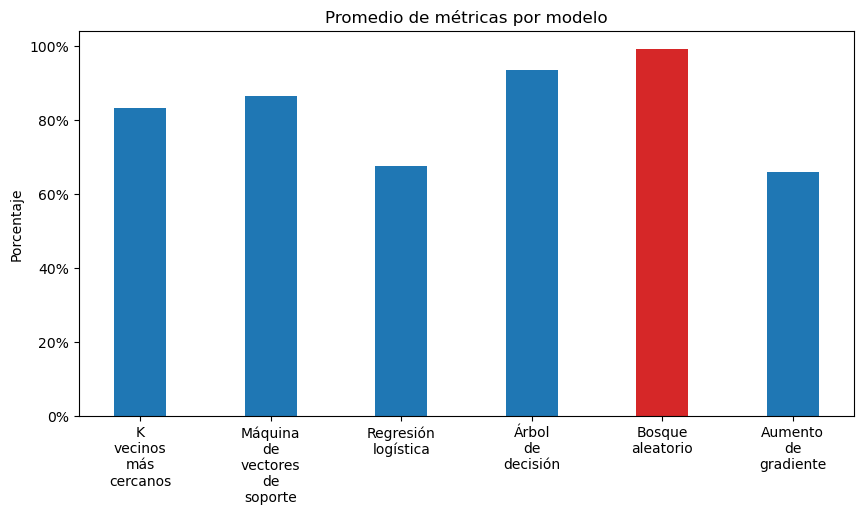

Algoritmo con mayor promedio de métricas: Bosque aleatorio
Exactitud: 99.54%
Precisión: 100.00%
Sensibilidad: 97.75%
Robustez: 98.87%
Tiempo: 3.79s
Promedio de métricas: 99.04%

Fin: 2023-07-06 10:38:08.741808
Tiempo: 0:08:50.999010


In [28]:
if __name__ == "__main__":
  main()